# Visualizations 

In [1]:
# Libraries 
import os
import torch
import argparse
import torchvision
import numpy as np
from glob import glob
import torch.utils.data
import matplotlib as mpl
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.nn import functional as F
from matplotlib import cm as color_map
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline

#Set reproducibility seeed
torch.manual_seed(1)

In [2]:
BATCH_SIZE = 32 # Not especified in paper

## MNIST Preprocessing as described in Appendix 4

# Add custom transformation that adds uniform [0,1] noise 
# to the integer pixel values between 0 and 255 and then 
# divide by 256, to obtain values in [0,1]
class AddNoiseToTensor(object):

    def __call__(self, pic):
        
        img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        tensor = img.float()
        return ( tensor + torch.rand(tensor.size())).div(256.)

## MNIST dataset
mnist_train_loader = torch.utils.data.DataLoader(
                            datasets.MNIST('../../data', train=True, download=True,
                            transform = AddNoiseToTensor()),
                            batch_size = BATCH_SIZE, shuffle = True)

mnist_test_loader = torch.utils.data.DataLoader(
                            datasets.MNIST('../../data', train=False, 
                            transform = AddNoiseToTensor()),
                            batch_size = BATCH_SIZE, shuffle = True)

## Qualitative Comparison Between Samples

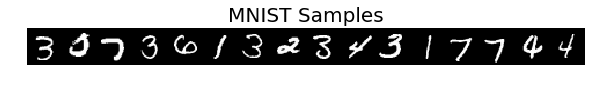

In [45]:
# Visualize dataset 
dataiter = iter(mnist_train_loader)
mnist_images, mnist_labels = dataiter.next()

def imshow(img, title = 'MNIST Samples'):
    npimg = img.numpy() # BlacK background
    plt.figure(figsize = (10, 10))
    plt.title(title, fontsize = 20)
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)), 
               interpolation = 'nearest')

# Display images with labels
imshow(torchvision.utils.make_grid(mnist_images[:16], 16 ))

In [4]:
# Visualization of samples from pre-trained models

#Check if cuda available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Set directory to parent
os.chdir('..')

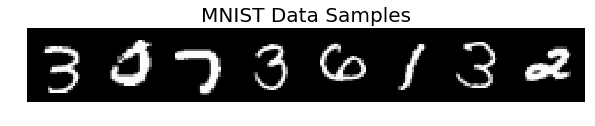

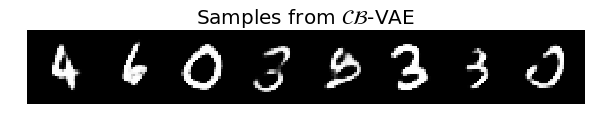

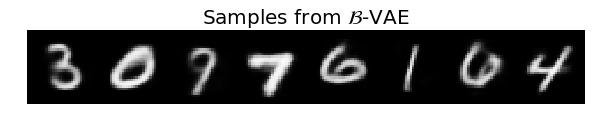

In [47]:
from models import *

model_vae = VAE().to(device)
model_cbvae = VAE().to(device)

# Load models 
model_vae.load_state_dict(torch.load('trained_models/VAE/run_2019-12-05_14-55_epoch_100.pt'))
model_cbvae.load_state_dict(torch.load('trained_models/CBVAE/run_2019-12-05_16-09_epoch_100.pt'))

# Sample from models 
model_vae.eval()
model_cbvae.eval()

sample = torch.randn(BATCH_SIZE, 20).to(device)

sample_vae = model_vae.decode(sample).cpu().view(BATCH_SIZE, 1, 28, 28).detach()
sample_cbvae = model_cbvae.decode(sample).cpu().view(BATCH_SIZE, 1, 28, 28).detach()

# Plot 
num_samples = 8
imshow(torchvision.utils.make_grid(mnist_images[:num_samples], 
                                   num_samples ), 'MNIST Data Samples')
imshow(torchvision.utils.make_grid( sample_cbvae[:num_samples], 
                                   num_samples ), 'Samples from $\mathcal{CB}$-VAE')
imshow(torchvision.utils.make_grid(sample_vae[:num_samples], 
                                   num_samples ), 'Samples from $\mathcal{B}$-VAE')